In [6]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Basic Usage

- https://huggingface.co/docs/diffusers/main/en/using-diffusers/sdxl
- https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_xl
 
SDXL Pipelines Source Code: https://github.com/huggingface/diffusers/tree/main/src/diffusers/pipelines/stable_diffusion_xl
- https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl_img2img.py

In [7]:
import torch
import diffusers
from src import helpers


In [8]:
refiner_id = "stabilityai/stable-diffusion-xl-refiner-1.0"

refiner = diffusers.StableDiffusionXLImg2ImgPipeline.from_pretrained(
    refiner_id,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.enable_model_cpu_offload()

# When using torch >= 2.0, you can improve the inference speed by 20-30% with torch.compile.
# Simple wrap the unet with torch compile before running the pipeline:
# if torch.__version__ >= "2.0":
#     print("Using torch.compile. The first run will be slow, but subsequent runs will be faster.")
#     pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

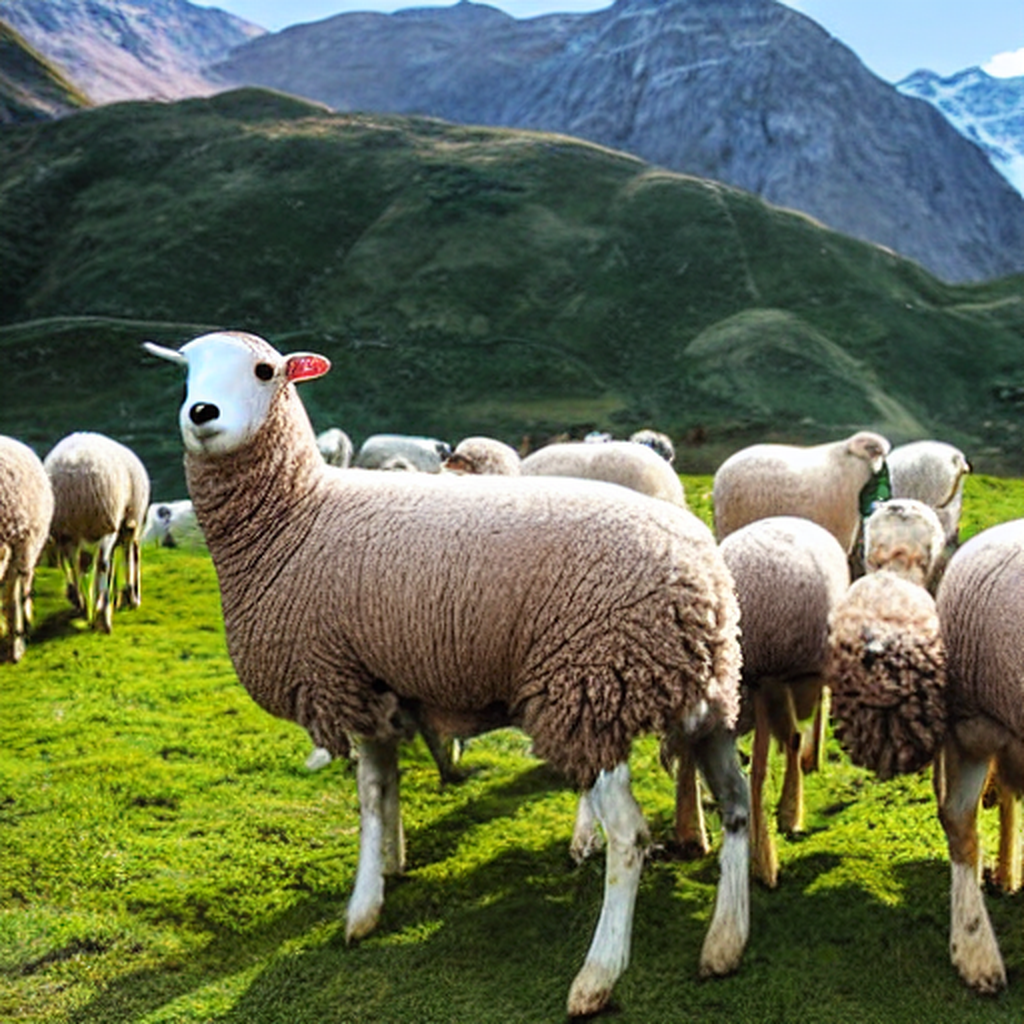

In [9]:
# read "output.png"
img = helpers.load_image("./output_imgs/txt2img/img_0003.png", 1024) # refiner trained with 1024x1024 images

img


  0%|          | 0/12 [00:00<?, ?it/s]

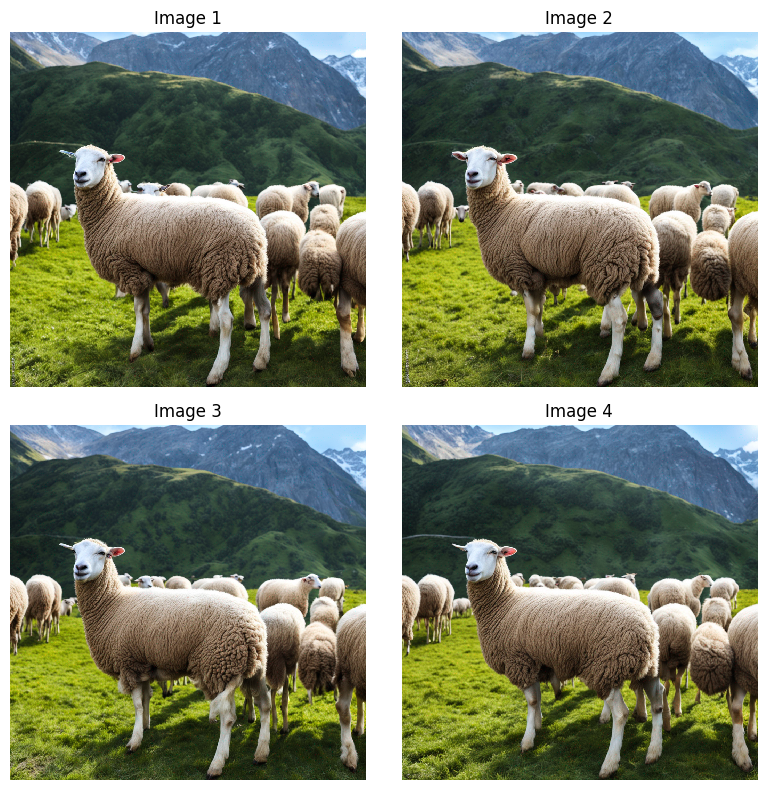

In [10]:
# == The prompt or prompts to guide the image generation.
#    If not defined, one has to pass `prompt_embeds` instead.
# prompt = "Two Linux penguin mascots Tux, eating an Apple logo. The Apple logo has a bite-mark in it on the top-right side of the apple. Caricature of the rivalry between Linux and Apple."
prompt = "flock of sheep are having selfie with a grazing on grassland, himalayan background extra detailed, highly realistic, extra detailed, himalayn landscape, hyper realistic"

# == The prompt or prompts not to guide the image generation.
#    If not defined, one has to pass `negative_prompt_embeds` instead.
#    Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`).
negative_prompt = "low-res, low quality, jpeg artifacts, blurry, grainy, distorted, ugly, out of frame, watermarked"

# == Other parameters
# == Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
#    `guidance_scale` is defined as `w` of equation 2. of [Imagen Paper](https://arxiv.org/pdf/2205.11487.pdf).
#    Guidance scale is enabled by setting `guidance_scale > 1`.
#    Higher guidance scale encourages to generate images that are closely linked to the text `prompt`, usually at the expense of lower image quality.
guidance_scale = 7.5  # Default: 7.5


# == The number of images to generate per prompt.
num_images_per_prompt = 4  # Default: 1

# ================================================================================================
seed = None

# == For deterministic results across runs, we create a torch.Generator using the seed value.
generator = None
if seed is not None:
    print(f"Using seed: {seed.value}")
    generator = torch.Generator().manual_seed(seed.value)


out = refiner(
    image=img,
    # Prompts & Guidance
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=guidance_scale,
    # Denoising
    strength=0.25,
    num_inference_steps=50,
    # Other
    generator=generator,
    num_images_per_prompt=num_images_per_prompt,
)

helpers.save_tmp_outputs(out.images, subdir="sdxl-refiner")
helpers.plot(out.images)
